In [1]:
"""
Author: Hyeon-Seo Yun 
Date: somewhere around Oct 25 2022
This notebook is a quick demonstration of training DNNs
with Higgs data from kaggle for Phys 570 AI course
in Purdue University for fall 2022 semester
"""
# ! pip install -q kaggle
# ! pip install opendatasets
# ! pip install brevitas
# ! pip install hls4ml

'\nAuthor: Hyeon-Seo Yun \nDate: somewhere around Oct 25 2022\nThis notebook is a quick demonstration of training DNNs\nwith Higgs data from kaggle for Phys 570 AI course\nin Purdue University for fall 2022 semester\n'

In [2]:
"""
unzip train datas (test here is not used)
"""
# ! unzip ./higgs-boson/test.zip -d ./higgs-boson/test/
# ! unzip ./test_data/higgs-boson/training.zip -d ./test_data/higgs-boson/training/

'\nunzip train datas (test here is not used)\n'

In [3]:
"""
Let's read the training csvs

"""
import pandas as pd
import numpy as np

df = pd.read_csv("./test_data/higgs-boson/training/training.csv")
# print(df.head()) # just printing what it looks like
df = df.drop(columns=['EventId', 'Weight']) # drop columns we don't use

In [4]:
"""
We filter out bad values
"""
df = df.replace(-999.000, np.nan)
df = df.dropna()
# print(df.head())

In [5]:
"""
We get rid of EventId column. Label column is our y (output). Rest is X (input)
"""
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy() # just get Label
# print(f"X shape: {X.shape}")
# print(f"Y shape: {Y.shape}")
# print(f"Y values b4: {Y}")
# turn the signal and background to 1 and 0 respectively
Y[Y == "s"] = 1
Y[Y == "b"] = 0
# print(np.any(Y == "s") or np.any(Y == "b")) # check if there's any non number left
# print(f"Y values after: {Y}")
Y = Y.astype('int32').reshape((-1,1))

In [6]:
# convert them into torch tensors bc we are gonna use pytorch
import torch
X = torch.Tensor(X)
Y = torch.Tensor(Y)

In [7]:
"""
We do the train test split. We don't shuffle the data just yet, we can do that 
pytorch data loader
"""
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"Y_train shape: {Y_train.shape}")
# print(f"Y_test shape: {Y_test.shape}")

In [8]:
np.__version__

'1.22.4'

In [9]:
"""
Now we gotta transfer the numpy data into a "dataset" so pytorch can load it as
as dataloader. This is not necessary, but a nice practice, since 
dataloaders shuffles data and you can change batch sizes easily
"""
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, X: Tensor, labels: Tensor):
    self.X = X
    self.Y = labels
  def __len__(self):
      return self.X.shape[0]
  def __getitem__(self, idx: int):
    x = self.X[idx]
    label = self.Y[idx]
    return x, label

dataset_train = CustomDataset(X_train, Y_train)
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)

# dataset_test = CustomDataset(X_test, Y_test)
# test_dataloader = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [10]:
# import torch.nn as nn 

# class three_layer_model(nn.Module):
#     def __init__(self):
#         # Model with <16,64,32,32,5> Behavior
#         super(three_layer_model, self).__init__()
#         self.quantized_model = False
#         self.input_shape = 30  # (,30)
#         self.fc1 = nn.Linear(self.input_shape, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 32)
#         self.fc4 = nn.Linear(32, 1)
#         self.act1 = nn.ReLU()
#         self.act2 = nn.ReLU()
#         self.act3 = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.act1(self.fc1(x))
#         x = self.act2(self.fc2(x))
#         x = self.act3(self.fc3(x))
#         sigmoid_out = self.sigmoid(self.fc4(x))
#         return sigmoid_out
# model = three_layer_model()

In [11]:
# """
# Training phase
# """
# import torch.nn.functional as F

# model.train() # put model in train mode (for batchnormalization)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# i = 0
# for x, y in train_dataloader:
#   loss = F.binary_cross_entropy(model(x), y)
#   i +=1
#   # if i > 100:
#   #   break

#   optimizer.zero_grad() # this deletes all previous grad calculations. very important
#   loss.backward() # calculates the gradients
#   optimizer.step() # applies backpropagation

In [12]:
# """
# Testing phase
# """
# from sklearn import metrics
# import matplotlib.pyplot as plt

# model.eval() # put model in eval mode (for batchnormalization)
# with torch.no_grad():
#   fpr, tpr, _ = metrics.roc_curve(Y_test,  model(X_test))
#   auc = metrics.roc_auc_score(Y_test, model(X_test))
  

# #create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()

In [13]:
from brevitas.nn import QuantLinear
from brevitas.quant import Int8WeightPerTensorFixedPoint
import math

# fc = QuantLinear(10, 5, bias=False, weight_quant=Int8WeightPerTensorFixedPoint)

quant_linear = QuantLinear(2, 4, weight_quant=Int8WeightPerTensorFixedPoint, bias=False)

print(quant_linear.quant_weight())
print(quant_linear.quant_weight().int())
# print(f"Weight QuantTensor:\n {quant_linear.quant_weight()}")
# print(f"Weight fix point: {- math.log2(quant_linear.quant_weight().scale)}")

QuantTensor(value=tensor([[-0.5312,  0.0703],
        [-0.3203,  0.2266],
        [-0.0391, -0.1797],
        [-0.5391, -0.3047]], grad_fn=<MulBackward0>), scale=tensor(0.0078, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(True))
tensor([[-68,   9],
        [-41,  29],
        [ -5, -23],
        [-69, -39]], dtype=torch.int32)


In [14]:
import inspect
from brevitas.nn import QuantLinear, QuantReLU
from IPython.display import Markdown, display

def pretty_print_source(source):
    display(Markdown('```python\n' + source + '\n```'))
    
# source = inspect.getsource(QuantLinear.__init__)  
# pretty_print_source(source)
source = inspect.getsource(QuantReLU.__init__)  
pretty_print_source(source)

```python
    def __init__(
            self,
            act_quant: Optional[ActQuantType] = Uint8ActPerTensorFloat,
            input_quant: Optional[ActQuantType] = None,
            return_quant_tensor: bool = False,
            **kwargs):
        QuantNLAL.__init__(
            self,
            act_impl=nn.ReLU,
            passthrough_act=True,
            input_quant=input_quant,
            act_quant=act_quant,
            return_quant_tensor=return_quant_tensor,
            **kwargs)

```

In [57]:
# """
# brevitas version
# """
# import torch.nn as nn 
# import brevitas.nn as qnn
# from brevitas.core.quant import QuantType

# class three_layer_model_bv(nn.Module):
#     def __init__(self):
#         # Model with <16,64,32,32,5> Behavior
#         super(three_layer_model_bv, self).__init__()
#         self.input_shape = int(30)  # (,16)
#         self.quantized_model = True #variable to inform some of our plotting functions this is quantized
#         self.weight_precision = 8
#         self.fc1 = qnn.QuantLinear(self.input_shape, int(64),
#                                    bias=True,
#                                    weight_quant_type=QuantType.INT,
#                                    weight_bit_width=self.weight_precision,
#                                    return_quant_tensor=True
#                                    )
#         self.fc2 = qnn.QuantLinear(64, 32,
#                                    bias=True,
#                                    weight_quant_type=QuantType.INT,
#                                    weight_bit_width=self.weight_precision,
#                                    return_quant_tensor=True
#                                    )
#         self.fc3 = qnn.QuantLinear(32, 32,
#                                    bias=True,
#                                    weight_quant_type=QuantType.INT,
#                                    weight_bit_width=self.weight_precision,
#                                    return_quant_tensor=True
#                                    )
#         self.fc4 = qnn.QuantLinear(32, 1,
#                                    bias=True,
#                                    weight_quant_type=QuantType.INT,
#                                    weight_bit_width=self.weight_precision,
#                                    return_quant_tensor=True
#                                    )
#         self.act1 = qnn.QuantReLU(
#             quant_type=QuantType.INT, 
#             bit_width=self.weight_precision, 
#             max_val=6,
#             return_quant_tensor=True
#         ) 
#         self.act2 = qnn.QuantReLU(
#             quant_type=QuantType.INT, 
#             bit_width=self.weight_precision, 
#             max_val=6,
#             return_quant_tensor=True
#         )
#         self.act3 = qnn.QuantReLU(
#             quant_type=QuantType.INT, 
#             bit_width=self.weight_precision, 
#             max_val=6,
#             return_quant_tensor=True
#         )
#         self.sigmoid = nn.Sigmoid()


#     def forward(self, x):
#         test = self.fc1(x)
#         x = self.act1(test)
#         x = self.act2(self.fc2(x))
#         x = self.act3(self.fc3(x))
#         # print(f"x: {x}")
#         x = self.fc4(x)
#         # print(f"fc output: {x}")
#         sigmoid_out = self.sigmoid(x)

#         return sigmoid_out


# model_bv = three_layer_model_bv()

In [58]:
# """
# Training phase
# """
# import torch.nn.functional as F

# model_bv.train() # put model in train mode (for batchnormalization)
# optimizer = torch.optim.AdamW(model_bv.parameters(), lr=1e-3)
# i = 0
# for x, y in train_dataloader:
#   # print(y.shape)
#   # print(model_bv(x).shape)
#   loss = F.binary_cross_entropy(model_bv(x), y)
#   i +=1
#   # if i > 100:
#   #   break

#   optimizer.zero_grad() # this deletes all previous grad calculations. very important
#   loss.backward() # calculates the gradients
#   optimizer.step() # applies backpropagation

In [59]:
# """
# Testing phase
# """
# from sklearn import metrics
# import matplotlib.pyplot as plt

# model_bv.eval() # put model in eval mode (for batchnormalization)
# with torch.no_grad():
#   fpr, tpr, _ = metrics.roc_curve(Y_test,  model_bv(X_test))
#   auc = metrics.roc_auc_score(Y_test, model_bv(X_test))
  

# #create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()

In [60]:
from brevitas.quant.scaled_int import Int8ActPerTensorFloat

"""class three_layer_model_bv_seq(nn.Module):
  def __init__(self):
      super(three_layer_model_bv_seq, self).__init__()
      input_dim = 30
      self.quantized_model = True #variable to inform some of our plotting functions this is quantized
      self.weight_precision = 8 # 8
      mlp_dims = [30 , 64, 32, 32]
      mlp_blocks = [nn.BatchNorm1d(input_dim)]
      for idx in range(len(mlp_dims)-1):
        # print(mlp_dims[idx + 1])
        mlp_blocks.append(qnn.QuantLinear(
                        int(mlp_dims[idx]), 
                        int(mlp_dims[idx + 1]),
                        bias=True,
                        weight_quant_type=QuantType.INT,
                        weight_bit_width=self.weight_precision,
                        return_quant_tensor=True,
                        input_quant=Int8ActPerTensorFloat
                        )
                        
        )
        mlp_blocks.append(
            qnn.QuantReLU(
                quant_type=QuantType.INT, 
                bit_width=self.weight_precision, 
                max_val=6, 
                return_quant_tensor=True
            )
        )
      # add last layer
      mlp_blocks.append(qnn.QuantLinear(
                        mlp_dims[len(mlp_dims)-1], 
                        1,
                        bias=True,
                        weight_quant_type=QuantType.INT,
                        weight_bit_width=self.weight_precision,
                        return_quant_tensor=True
                        )
        )
      mlp_blocks.append(nn.Sigmoid())
      self.mlp = nn.Sequential(*mlp_blocks)

  def forward(self, X: Tensor):
      return self.mlp(X)

model_bv_seq = three_layer_model_bv_seq()"""

'class three_layer_model_bv_seq(nn.Module):\n  def __init__(self):\n      super(three_layer_model_bv_seq, self).__init__()\n      input_dim = 30\n      self.quantized_model = True #variable to inform some of our plotting functions this is quantized\n      self.weight_precision = 8 # 8\n      mlp_dims = [30 , 64, 32, 32]\n      mlp_blocks = [nn.BatchNorm1d(input_dim)]\n      for idx in range(len(mlp_dims)-1):\n        # print(mlp_dims[idx + 1])\n        mlp_blocks.append(qnn.QuantLinear(\n                        int(mlp_dims[idx]), \n                        int(mlp_dims[idx + 1]),\n                        bias=True,\n                        weight_quant_type=QuantType.INT,\n                        weight_bit_width=self.weight_precision,\n                        return_quant_tensor=True,\n                        input_quant=Int8ActPerTensorFloat\n                        )\n                        \n        )\n        mlp_blocks.append(\n            qnn.QuantReLU(\n                quant_t

In [37]:
# import brevitas.nn as qnn
# from brevitas.core.quant import QuantType
# from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
# from brevitas.quant.shifted_scaled_int import ShiftedUint8ActPerTensorFloat

# """
# NOTE: try quantizing the input data and 
# see if there's big changes
# """

# input_dim = 30
# weight_precision = 8 # 8
# # mlp_dims = [30 , 64, 32, 32]
# mlp_dims = [30 , 16, 8, 8]
# mlp_blocks = [nn.BatchNorm1d(input_dim)]
# for idx in range(len(mlp_dims)-1):
#   # print(mlp_dims[idx + 1])
#   # mlp_blocks.append(qnn.QuantLinear(
#   #                 int(mlp_dims[idx]), 
#   #                 int(mlp_dims[idx + 1]),
#   #                 bias=True,
#   #                 weight_quant_type=QuantType.INT,
#   #                 weight_bit_width=weight_precision,
#   #                 return_quant_tensor=True,
#   #                 output_quant=Int8ActPerTensorFloat,
#   #                 input_quant=Int8ActPerTensorFloat
#   #                 )
                  
#   # )
#   mlp_blocks.append(qnn.QuantLinear(
#                   int(mlp_dims[idx]), 
#                   int(mlp_dims[idx + 1]),
#                   bias=True,
#                   input_bit_width=weight_precision,
#                   output_bit_width=weight_precision,
#                   weight_quant=Int8WeightPerTensorFloat,
#                   input_quant=ShiftedUint8ActPerTensorFloat,
#                   output_quant=ShiftedUint8ActPerTensorFloat,
#                   return_quant_tensor=True
#                   )
                  
#   )
#   mlp_blocks.append(
#       qnn.QuantReLU(
#           quant_type=QuantType.INT, 
#           bit_width=weight_precision, 
#           max_val=6, 
#           return_quant_tensor=True
#       )
#   )
# # add last layer
# mlp_blocks.append(qnn.QuantLinear(
#                   mlp_dims[len(mlp_dims)-1], 
#                   1,
#                   bias=True,
#                   input_bit_width=weight_precision,
#                   output_bit_width=weight_precision,
#                   weight_quant=Int8WeightPerTensorFloat,
#                   input_quant=ShiftedUint8ActPerTensorFloat,
#                   output_quant=ShiftedUint8ActPerTensorFloat,
#                   return_quant_tensor=True
#                   )
#   )
# # mlp_blocks.append(nn.Sigmoid())
# mlp_blocks.append(
#       qnn.QuantSigmoid(
#           quant_type=QuantType.INT, 
#           bit_width=weight_precision, 
#           max_val=6, 
#           return_quant_tensor=True
#       )
#   )
# model_bv_seq = nn.Sequential(*mlp_blocks)


In [119]:
import brevitas.quant.fixed_point as fp

quant =fp.Int8WeightPerTensorFixedPoint
print(quant.bit_width)
quant.bit_width = 16
print(quant.bit_width)
print(fp.Int8WeightPerTensorFixedPoint.bit_width)

DependencyError: ignored

In [88]:
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from brevitas.quant.shifted_scaled_int import ShiftedUint8ActPerTensorFloat
import brevitas.quant.fixed_point as fp
"""
NOTE: try quantizing the input data and 
see if there's big changes
"""

input_dim = 30
weight_precision = 16 # 8
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
# mlp_dims = [30 , 128, 64, 64]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
weight_quant = fp.Int8WeightPerTensorFixedPoint
weight_quant.bit_width = weight_precision


for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(qnn.QuantLinear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True,
                  weight_quant=weight_quant,
                  bias_quant=fp.Int8BiasPerTensorFixedPointInternalScaling,
                  input_quant=fp.Uint8ActPerTensorFixedPoint,
                  return_quant_tensor=True
                  )  
  )
  
  mlp_blocks.append(
      qnn.QuantReLU(
          act_quant=fp.Uint8ActPerTensorFixedPoint,
          return_quant_tensor=True
      )
  )
# add last layer
mlp_blocks.append(qnn.QuantLinear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  weight_quant=fp.Int8WeightPerTensorFixedPoint,
                  bias_quant=fp.Int8BiasPerTensorFixedPointInternalScaling,
                  input_quant=fp.Uint8ActPerTensorFixedPoint,
                  return_quant_tensor=True
                  )
)
mlp_blocks.append(
      qnn.QuantSigmoid(
          act_quant=fp.Uint8ActPerTensorFixedPoint,
          return_quant_tensor=True
      )
)
model_bv_seq = nn.Sequential(*mlp_blocks)


In [70]:
# import brevitas.nn as qnn
# from brevitas.core.quant import QuantType
# from brevitas.quant.scaled_int import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
# from brevitas.quant.shifted_scaled_int import ShiftedUint8ActPerTensorFloat

# """
# NOTE: try quantizing the input data and 
# see if there's big changes

# Ben Hawk's way to writing bv code
# """

# input_dim = 30
# weight_precision = 8 # 8
# # mlp_dims = [30 , 64, 32, 32]
# mlp_dims = [30 , 16, 8, 8]
# mlp_blocks = [nn.BatchNorm1d(input_dim)]
# for idx in range(len(mlp_dims)-1):
#   # print(mlp_dims[idx + 1])
#   mlp_blocks.append(qnn.QuantLinear(
#                   int(mlp_dims[idx]), 
#                   int(mlp_dims[idx + 1]),
#                   bias=True,
#                   weight_quant_type=QuantType.INT,
#                   weight_bit_width=weight_precision,
#                   return_quant_tensor=True
#                   )  
#   )
  
#   mlp_blocks.append(
#       qnn.QuantReLU(
#           quant_type=QuantType.INT, 
#           bit_width=weight_precision, 
#           max_val=6, 
#           return_quant_tensor=True
#       )
#   )
# # add last layer
# mlp_blocks.append(qnn.QuantLinear(
#                   mlp_dims[len(mlp_dims)-1], 
#                   1,
#                   bias=True,
#                   weight_quant_type=QuantType.INT,
#                   weight_bit_width=weight_precision,
#                   return_quant_tensor=True
#                   )
# )
# mlp_blocks.append(
#       qnn.QuantSigmoid(
#           quant_type=QuantType.INT, 
#           bit_width=weight_precision, 
#           max_val=6, 
#           return_quant_tensor=True
#       )
# )
# model_bv_seq = nn.Sequential(*mlp_blocks)


In [89]:
"""
Training phase
"""
import torch.nn.functional as F

model_bv_seq.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(model_bv_seq.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(model_bv_seq(x).shape)
  loss = F.binary_cross_entropy(model_bv_seq(x), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation

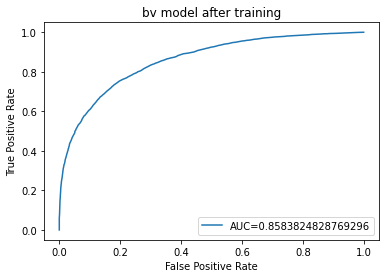

In [90]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

model_bv_seq.eval() # put model in eval mode 
with torch.no_grad():
  Y_hat = model_bv_seq(X_test)[0]
  fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat)
  auc = metrics.roc_auc_score(Y_test, Y_hat)
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("bv model after training")
plt.legend(loc=4)
plt.show()

In [91]:
# print(len(model_bv_seq.mlp))
# print((model_bv_seq.mlp))
N_test = X_test.shape[0]
sample_size = 10
bins = 500
sample_idxs = np.random.choice(N_test, sample_size)
# print(X_test.shape)

quantlinear layer tensor bit_width: 22.0


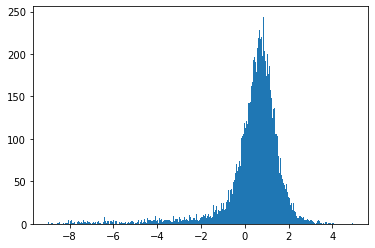

hidden activation layer tensor bit_width: 8.0


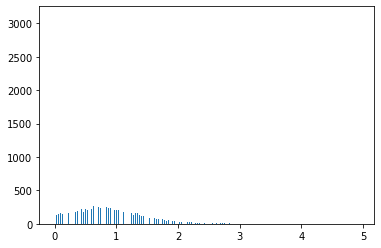

quantlinear layer tensor bit_width: 21.0


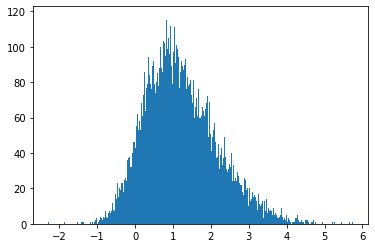

hidden activation layer tensor bit_width: 8.0


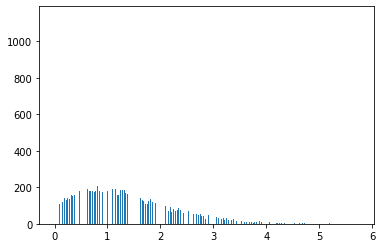

quantlinear layer tensor bit_width: 20.0


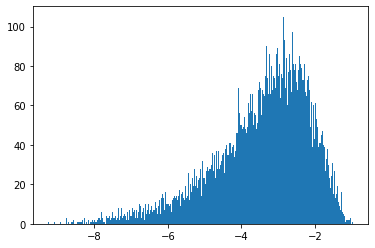

hidden activation layer tensor bit_width: 8.0


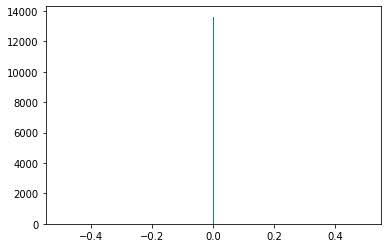

output quantlinear layer tensor bit_width: 20.0


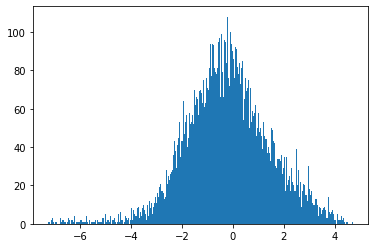

QuantSigmoid activation
QuantSigmoid output: torch.Size([13623, 1])


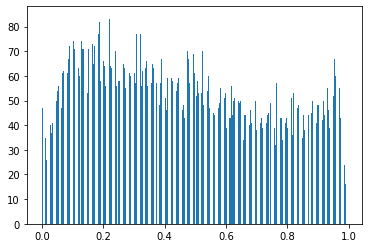

In [92]:
"""
plot histograms
"""
from sklearn import metrics
import matplotlib.pyplot as plt


model_bv_seq.eval() # put model in eval mode (for batchnormalization)
with torch.no_grad():
  # y_hat = model_bv_seq[0](X_test[sample_idxs])
  y_hat = model_bv_seq[0](X_test) # batchnorm

  for idx in range(1,len(model_bv_seq)-2):
    # print(f"idx: {idx}")
    y_hat = model_bv_seq[idx](y_hat)
    if idx%2 ==1: # quantlinear
      print(f"quantlinear layer tensor bit_width: {y_hat.bit_width}")
    else:# activation
      print(f"hidden activation layer tensor bit_width: {y_hat.bit_width}")
    
    plt.hist(y_hat[0][:,0], bins= bins)
    plt.show()

  idx = len(model_bv_seq)-2
  y_hat = model_bv_seq[idx](y_hat)
  print(f"output quantlinear layer tensor bit_width: {y_hat.bit_width}")
  plt.hist(y_hat[0][:,0], bins= bins)
  plt.show()
  idx = len(model_bv_seq)-1
  y_hat = model_bv_seq[idx](y_hat)
  # print(f"output activation layer tensor : {y_hat}")
  # print("Sigmoid activation")
  # plt.hist(y_hat.flatten(), bins= bins)

  print("QuantSigmoid activation")
  print(f"QuantSigmoid output: {y_hat[0].shape}")
  plt.hist(y_hat[0].flatten(), bins= bins)

  plt.show()

    
  



In [114]:
# print(model_bv_seq.mlp[0])
# print(model_bv_seq.mlp[0].__str__)
# print(len(model_bv_seq.mlp))
# for idx in range(1,len(model_bv_seq.mlp)-2):
#     print(f"idx: {idx}")

idx: 1
idx: 2
idx: 3
idx: 4
idx: 5


In [93]:
"""
IMPORTANT
save the model to layer load it in a normal sequential for hls4ml
"""
save_path = "./model.pt"
torch.save(model_bv_seq.state_dict(), save_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1366: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  "Positional args are being deprecated, use kwargs instead. Refer to "


In [94]:
"""
define and initialize the torch model for hls4ml conversion.
Pls note that nn.Sigmoid() is commented out as that is not supported by hls4ml
"""
import copy

input_dim = 30
weight_precision = 8 # 8
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(nn.Linear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True
                  )
                  
  )
  mlp_blocks.append(
      nn.ReLU()
  )
# add last layer
mlp_blocks.append(nn.Linear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  )
  )
# mlp_blocks.append(nn.Sigmoid())
torch_model = nn.Sequential(*mlp_blocks)
state_dict = torch.load(save_path)
state_dict_copy = copy.deepcopy(state_dict)
for key, value in state_dict.items():
  if "quant" in key:
    del state_dict_copy[key]
# print(f"new state dict without quantization keys: {state_dict_copy}")
torch_model.load_state_dict(state_dict_copy)

<All keys matched successfully>

config: {'Model': {'Precision': 'ap_fixed<15,9>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
MSE torch vs hls test output: 0.03025924414396286


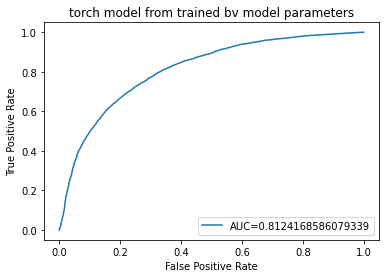

In [95]:
"""
check if torch hls conversion is good
"""
import hls4ml 
from sklearn.metrics import mean_squared_error

int_bit = 9 #14
fract_bit = 6 #20
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
config = hls4ml.utils.config_from_pytorch_model(torch_model,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(torch_model,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
X_hls_test = np.ascontiguousarray(X_test)
Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

torch_model.eval()
with torch.no_grad():
  Y_hat_torch = torch.sigmoid(torch_model(X_test))
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE torch vs hls test output: {MSE}")

fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("torch model from trained bv model parameters")
plt.legend(loc=4)
plt.show()

In [110]:
"""
Now doing Post Training Quantization with hls4ml to compare performance
Parameter search over integer bits. Fractional bits frozen at 20    
"""


print(hls4ml.__version__)

fract_bit = 14
aurocs_int_q = []
ap_fixed_configs_int = []

for int_bit in range(2,13,1): 
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(torch_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(torch_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    Y_hat = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))
    auc = metrics.roc_auc_score(Y_test, Y_hat.cpu().numpy())
    aurocs_int_q.append(auc)
    # ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    ap_fixed_configs_int.append(int_bit)
    

0.6.0
config: {'Model': {'Precision': 'ap_fixed<16,2>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<17,3>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer 

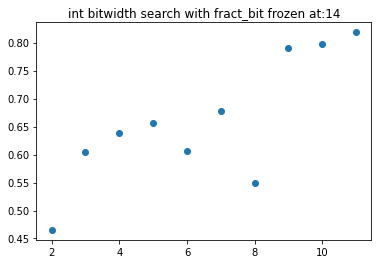

In [111]:
plt.scatter(ap_fixed_configs_int, aurocs_int_q)
plt.title(f"int bitwidth search with fract_bit frozen at:{fract_bit}")
plt.show()

In [113]:
"""
Parameter search over fractional bits. Integer bits frozen at 11   
"""
int_bit = 11
aurocs_fract_q = []
ap_fixed_configs_fract = []

for fract_bit in range(2,32,2):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(torch_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(torch_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract_q.append(auc)
    # ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")
    ap_fixed_configs_fract.append(fract_bit)
    


config: {'Model': {'Precision': 'ap_fixed<13,11>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<15,11>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type

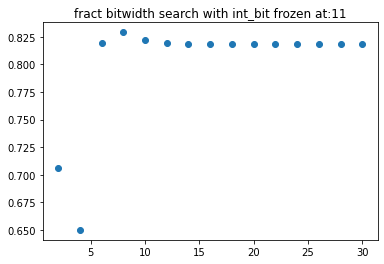

In [114]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract_q)
plt.title(f"fract bitwidth search with int_bit frozen at:{int_bit}")
plt.show()

In [51]:
"""
Start normal model and train it normally for comparison of PTQ
"""
input_dim = 30
weight_precision = 8 # 8
# mlp_dims = [30 , 64, 32, 32]
mlp_dims = [30 , 16, 8, 8]
mlp_blocks = [nn.BatchNorm1d(input_dim)]
for idx in range(len(mlp_dims)-1):
  # print(mlp_dims[idx + 1])
  mlp_blocks.append(nn.Linear(
                  int(mlp_dims[idx]), 
                  int(mlp_dims[idx + 1]),
                  bias=True
                  )
                  
  )
  mlp_blocks.append(
      nn.ReLU()
  )
# add last layer
mlp_blocks.append(nn.Linear(
                  mlp_dims[len(mlp_dims)-1], 
                  1,
                  bias=True,
                  )
  )

normal_model = nn.Sequential(*mlp_blocks)


In [52]:
"""
Training phase
NOTE: no sigmoid in the model itself
"""
import torch.nn.functional as F

normal_model.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(normal_model.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(normal_model(x).shape)
  logit = normal_model(x)
  loss = F.binary_cross_entropy(torch.sigmoid(logit), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation
  

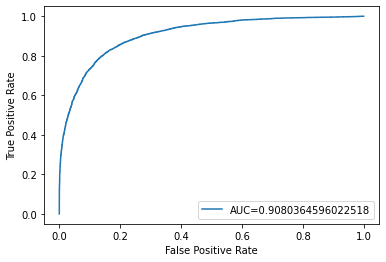

In [53]:
"""
Testing phase
"""


normal_model.eval() # put model in eval mode 
with torch.no_grad():
  logit = normal_model(X_test)
  fpr, tpr, _ = metrics.roc_curve(Y_test,  torch.sigmoid(logit))
  auc = metrics.roc_auc_score(Y_test, torch.sigmoid(logit))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

config: {'Model': {'Precision': 'ap_fixed<34,14>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
MSE torch vs hls test output: 1.5880913251109519e-10


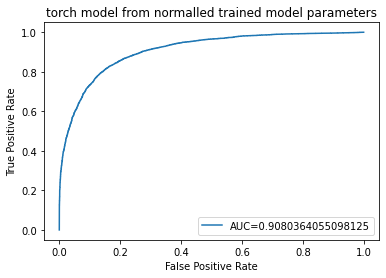

In [55]:
"""
check if torch hls conversion is good for normal model
"""
import hls4ml 
from sklearn.metrics import mean_squared_error

int_bit = 14 #14
fract_bit = 20 #20
total_bit = int_bit + fract_bit
ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                    default_precision=ap_fixed_config,
                                    granularity='model'
)
print(f"config: {config}")
hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                    hls_config=config,
                                                    output_dir='model_1/hls4ml_prj',
                                                    part='xcu250-figd2104-2L-e',
                                                    input_shape = (100,30) # 100 here is irrelevant
)
hls_model.compile()
X_hls_test = np.ascontiguousarray(X_test)
Y_hat_hls = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))

normal_model.eval()
with torch.no_grad():
  Y_hat_torch = torch.sigmoid(normal_model(X_test))
MSE = mean_squared_error(Y_hat_torch.cpu().numpy(), Y_hat_hls.cpu().numpy())
print(f"MSE torch vs hls test output: {MSE}")


fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_hat_hls.cpu().numpy())
auc = metrics.roc_auc_score(Y_test, Y_hat_hls.cpu().numpy())
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("torch model from normalled trained model parameters")
plt.legend(loc=4)
plt.show()

In [56]:
"""
PTQ with normal model
Parameter search over integer bits. Fractional bits frozen at 20    
"""
import hls4ml 

print(hls4ml.__version__)

fract_bit = 20
aurocs_int = []
ap_fixed_configs_int = []

for int_bit in range(8,15,1): # search from 2 to 32, with with 4 bit intervals
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    Y_hat = torch.sigmoid(torch.from_numpy(hls_model.predict(X_hls_test)))
    auc = metrics.roc_auc_score(Y_test, Y_hat.cpu().numpy())
    aurocs_int.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    

0.6.0
config: {'Model': {'Precision': 'ap_fixed<28,8>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<29,9>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer 

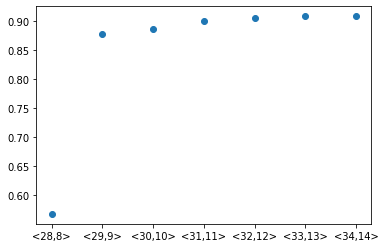

In [57]:
plt.scatter(ap_fixed_configs_int, aurocs_int)

In [58]:
"""
Parameter search over fractional bits. Integer bits frozen at 13    
"""
int_bit = 13
aurocs_fract = []
ap_fixed_configs_fract = []

for fract_bit in range(6,13,1):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_pytorch_model(normal_model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    print(f"config: {config}")
    hls_model = hls4ml.converters.convert_from_pytorch_model(normal_model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e',
                                                        input_shape = (100,30) # 100 here is irrelevant
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")


config: {'Model': {'Precision': 'ap_fixed<19,13>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type: Activation, input shape: [[100, 16]]
Layer name: 3, layer type: Dense, input shape: [[100, 16]]
Layer name: 4, layer type: Activation, input shape: [[100, 8]]
Layer name: 5, layer type: Dense, input shape: [[100, 8]]
Layer name: 6, layer type: Activation, input shape: [[100, 8]]
Layer name: 7, layer type: Dense, input shape: [[100, 8]]
Creating HLS model
Writing HLS project
Done
config: {'Model': {'Precision': 'ap_fixed<20,13>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Model ...
Topology:
Input Shape:  [[100, 30]]
Layer name: 0, layer type: BatchNormalization, input shape: [[100, 30]]
Layer name: 1, layer type: Dense, input shape: [[100, 30]]
Layer name: 2, layer type

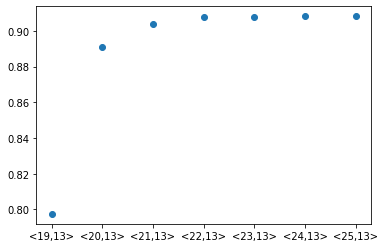

In [59]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract)

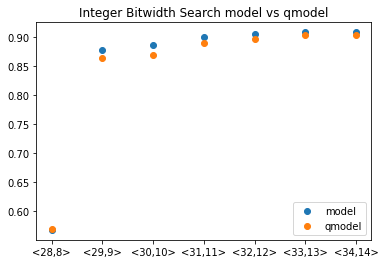

In [60]:
plt.scatter(ap_fixed_configs_int, aurocs_int, label="model")
plt.scatter(ap_fixed_configs_int, aurocs_int_q, label="qmodel")
plt.legend()
plt.title("Integer Bitwidth Search model vs qmodel")
plt.show()

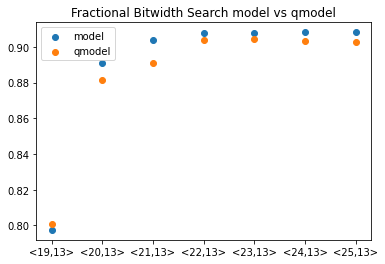

In [61]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract, label="model")
plt.scatter(ap_fixed_configs_fract, aurocs_fract_q, label="qmodel")
plt.legend()
plt.title("Fractional Bitwidth Search model vs qmodel")
plt.show()

In [163]:
save_path = "./test_model.pt"
torch.save(torch_model, save_path)

fract_bit = 20
aurocs_int_q = []
ap_fixed_configs_int = []



for int_bit in range(10,15,1): # search from 2 to 32, with with 4 bit intervals
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    yamlConfig=  {
    'PytorchModel': './test_model.pt',
    'OutputDir': 'my-torch-test', 
    'ProjectName': 'mytorchproject', 
    'XilinxPart': 'xcu250-figd2104-2L-e',
      'ClockPeriod': 5, 'IOType': 'io_parallel', 
      'HLSConfig': {'Model': {'Precision': ap_fixed_config, 'ReuseFactor': 1}},
      'InputShape' : f"(100,{input_dim})" # 100 here is irrelevant
    }



    hls_model = hls4ml.converters.pytorch_to_hls(yamlConfig)
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_int_q.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    

Interpreting Model ...


NameError: ignored

In [49]:
class three_layer_model_seq(nn.Module):
  def __init__(self):
    # Model with <16,64,32,32,5> Behavior
    super(three_layer_model_seq, self).__init__()
    input_dim = 30
    mlp_dims = [30 , 64, 32, 32]
    mlp_blocks = []
    for idx in range(len(mlp_dims)-1):
      # print(mlp_dims[idx + 1])
      mlp_blocks.append(nn.Linear(mlp_dims[idx], mlp_dims[idx + 1]))
      mlp_blocks.append(nn.ReLU())
    # add last layer
    mlp_blocks.append(nn.Linear(mlp_dims[len(mlp_dims)-1], 1))
    mlp_blocks.append(nn.Sigmoid())
    self.mlp = nn.Sequential(*mlp_blocks)

  def forward(self, X: Tensor):
      return self.mlp(X)
model_seq = three_layer_model_seq()

In [50]:
"""
Training phase
"""
import torch.nn.functional as F

model_seq.train() # put model in train mode (for batchnormalization)
optimizer = torch.optim.AdamW(model_seq.parameters(), lr=1e-3)
i = 0
for x, y in train_dataloader:
  # print(y.shape)
  # print(model_seq(x).shape)
  loss = F.binary_cross_entropy(model_seq(x), y)
  i +=1
  # if i > 100:
  #   break

  optimizer.zero_grad() # this deletes all previous grad calculations. very important
  loss.backward() # calculates the gradients
  optimizer.step() # applies backpropagation

In [51]:
print(len(model_seq.mlp))
# print((model_seq.mlp))


8


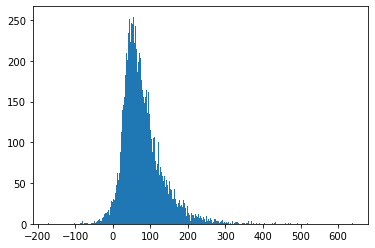

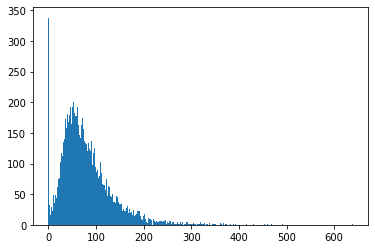

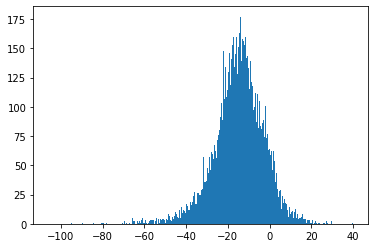

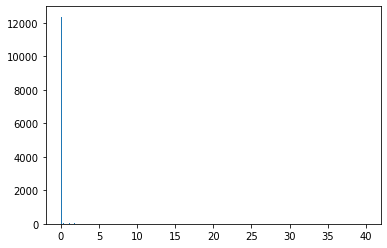

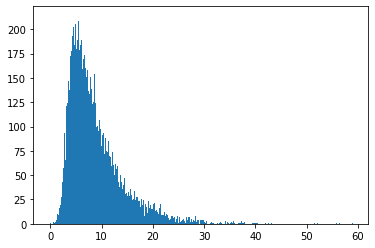

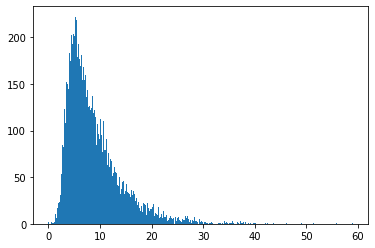

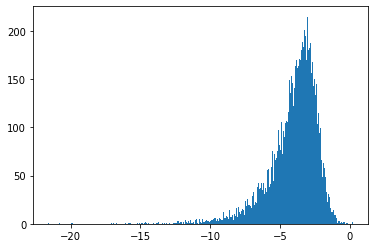

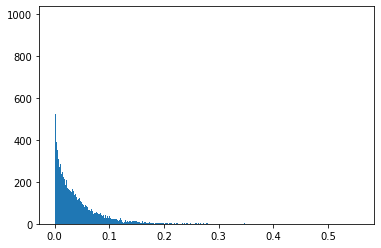

In [73]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

model_seq.eval() # put model in eval mode (for batchnormalization)
with torch.no_grad():
  # y_hat = model_seq.mlp[0](X_test[sample_idxs])

  y_hat = model_bv_seq.mlp[0](X_test)
  plt.hist(y_hat[:,0], bins= bins)
  plt.show()
  for idx in range(1,len(model_seq.mlp)):
    y_hat = model_seq.mlp[idx](y_hat)
    plt.hist(y_hat[:,0], bins= bins)
    plt.show()
  

